# Catchment areas for stroke units

This notebook shows how to determine the closest acute stroke unit to any patient in any part of England and Wales or of Northern Ireland.

## Plain English summary

Usually we assume that when an ambulance is taking a patient to an acute stroke unit, the ambulance will choose to go to the nearest acute stroke unit out of all available options.

Every area of England and Wales is in a single Lower Super Output Area (LSOA) and every area of Northern Ireland is in a single Small Area (SA). By calculating the travel time from every LSOA or SA to every stroke unit, we can calculate which acute stroke unit is closest to any patient anywhere.

Looking at it the other way around, we can find which areas of the country are in each stroke unit's "catchment area".

## Aims

This notebook shows how to use the `stroke-maps` package to find the catchment area of each acute stroke unit.

## Method

+ Load a list of the LSOA or Small Areas
+ Load a list of the travel times from each area to each stroke unit
+ Find the stroke unit with the minimum time to each area
+ Create a map of the resulting catchment areas

## Notebook setup

In [1]:
import stroke_maps.load_data
import stroke_maps.catchment
import stroke_maps.geo  # to make catchment area geometry

import pandas as pd
import matplotlib.pyplot as plt
from mapclassify import greedy  # to assign colours to regions on map.
                                # ^ also requires libpysal.

## England and Wales

### Load data

__LSOA travel time__

This dataframe contains one row for each LSOA in England and Wales. There is one column for each stroke unit in England and Wales. The value in each cell is the time from that row's LSOA to that column's stroke unit.

In [2]:
df_travel_lsoa = stroke_maps.load_data.travel_time_matrix_lsoa()

# Show the first five rows and columns:
df_travel_lsoa.iloc[:5, :5]

,B152TH,B714HJ,B95SS,BA13NG,BA214AT
LSOA,,,,,
Adur 001A,173.3,179.8,171.2,161.5,152.9
Adur 001B,173.3,179.8,172.3,161.5,152.9
Adur 001C,173.3,180.9,172.3,150.8,151.9
Adur 001D,173.3,180.9,172.3,161.5,152.9
Adur 001E,174.4,180.9,173.3,150.8,151.9


Write how many LSOA and then how many stroke teams are in this matrix:

In [3]:
df_travel_lsoa.shape

(34752, 125)

__Stroke unit services__

This dataframe contains information on which stroke units provide which services (IVT and MT). The imported dataframe, df_units, contains only units that appear in the travel time matrix. This includes units that are not acute stroke units (i.e. provide neither thrombolysis nor thrombectomy).

In [4]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

df_units.head(3).T

postcode,SY231ER,CB20QQ,L97AL
stroke_team,Bronglais Hospital (Aberystwyth),"Addenbrooke's Hospital, Cambridge","University Hospital Aintree, Liverpool"
short_code,AB,AD,AI
ssnap_name,Bronglais Hospital,Addenbrooke's Hospital,University Hospital Aintree
use_ivt,1,1,1
use_mt,0,1,1
use_msu,0,1,1
transfer_unit_postcode,nearest,nearest,nearest
lsoa,Ceredigion 002A,Cambridge 013D,Liverpool 005A
lsoa_code,W01000512,E01017995,E01006654
region,Hywel Dda University Health Board,NHS Cambridgeshire and Peterborough ICB - 06H,NHS Cheshire and Merseyside ICB - 99A


### Calculate nearest acute stroke unit

The full travel time matrix gives the time from every LSOA to every stroke unit, including those that don't provide acute care. Realistically an ambulance should never choose to take the patient to those units.

Firstly, find a list of stroke units that offer acute care. These are units where `use_ivt` and/or `use_mt` are equal to 1 (one).

In [5]:
mask_acute = ((df_units['use_ivt'] == 1) | (df_units['use_mt'] == 1))

postcodes_acute_units = df_units[mask_acute].index.values

Check how many postcodes are in this list compared with how many stroke units are in the full dataframe:

In [6]:
n_units = len(df_units)
n_units_acute = len(postcodes_acute_units)

print(n_units, n_units_acute)

141 113


Now make a copy of the travel time matrix that only includes times to these units:

In [7]:
df_travel_lsoa_acute = df_travel_lsoa[postcodes_acute_units].copy()

# (Number of LSOA, number of stroke teams)
df_travel_lsoa_acute.shape

(34752, 113)

Run the function to find which of the units in the reduced dataframe is closest to each LSOA:

In [8]:
df_catchment_acute = stroke_maps.catchment.find_nearest_unit(df_travel_lsoa_acute)

df_catchment_acute.head(5)

,unit_travel_time,unit_postcode
LSOA,,
Adur 001A,17.6,BN25BE
Adur 001B,18.7,BN25BE
Adur 001C,17.6,BN112DH
Adur 001D,17.6,BN112DH
Adur 001E,16.5,BN112DH


### Calculate nearest thrombectomy unit

We can use a very similar method to before by only keeping stroke units that offer thrombectomy (MT):

In [9]:
mask_mt = (df_units['use_mt'] == 1)

postcodes_mt_units = df_units[mask_mt].index.values

Check how many postcodes are in this list compared with how many stroke units are in the full dataframe:

In [10]:
n_units = len(df_units)
n_units_mt = len(postcodes_mt_units)

print(n_units, n_units_mt)

141 25


Now make a copy of the travel time matrix that includes times to only these units:

In [11]:
df_travel_lsoa_mt = df_travel_lsoa[postcodes_mt_units].copy()

# (Number of LSOA, number of stroke teams)
df_travel_lsoa_mt.shape

(34752, 25)

Run the function to find which of the units in the reduced dataframe is closest to each LSOA:

In [12]:
df_catchment_mt = stroke_maps.catchment.find_nearest_unit(df_travel_lsoa_mt)

df_catchment_mt.head(5)

,unit_travel_time,unit_postcode
LSOA,,
Adur 001A,17.6,BN25BE
Adur 001B,18.7,BN25BE
Adur 001C,19.8,BN25BE
Adur 001D,19.8,BN25BE
Adur 001E,19.8,BN25BE


### Calculate nearest transfer unit

The method for finding transfer units is shown in more detail in _the transfer units demonstration_ (__TO DO__: add link to this).

In [13]:
df_transfer = stroke_maps.catchment.calculate_transfer_units(df_units)

In [14]:
df_transfer

,transfer_unit_travel_time,transfer_unit_postcode
postcode,,
SY231ER,135.8,CF144XW
CB20QQ,0.0,CB20QQ
L97AL,0.0,L97AL
CH495PE,27.3,L97AL
BA13NG,33.7,BS105NB
...,...,...
SL24HL,NaN,<NA>
HP112TT,34.8,OX39DU
BA214AT,74.5,BS105NB


### Combine results for nearest acute, MT, and transfer units

In [15]:
# Combine nearest unit and nearest MT unit:
df_results = pd.merge(
    df_catchment_acute, df_catchment_mt,
    left_index=True, right_index=True, how='left',
    suffixes=['_acute', '_mt']
)
# Combine these with the nearest unit's transfer unit:
df_results = pd.merge(
    df_results, df_transfer,
    left_on='unit_postcode_acute', right_index=True, how='left',
)

In [16]:
df_results.head(5)

,unit_travel_time_acute,unit_postcode_acute,unit_travel_time_mt,unit_postcode_mt,transfer_unit_travel_time,transfer_unit_postcode
LSOA,,,,,,
Adur 001A,17.6,BN25BE,17.6,BN25BE,0.0,BN25BE
Adur 001B,18.7,BN25BE,18.7,BN25BE,0.0,BN25BE
Adur 001C,17.6,BN112DH,19.8,BN25BE,31.6,BN25BE
Adur 001D,17.6,BN112DH,19.8,BN25BE,31.6,BN25BE
Adur 001E,16.5,BN112DH,19.8,BN25BE,31.6,BN25BE


### Plot the catchment areas

__Set up catchment data for plot__

First, load the LSOA boundaries:

In [17]:
gdf_lsoa = stroke_maps.load_data.lsoa_geography()

gdf_lsoa.head(3)

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,GlobalID,geometry
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.09706,51.51810,157794.481079,1685.391778,b12173a3-5423-4672-a5eb-f152d2345f96,"POLYGON ((-0.09474 51.52060, -0.09546 51.51544..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.09197,51.51868,164882.427628,1804.828196,90274dc4-f785-4afb-95cd-7cc1fc9a2cad,"POLYGON ((-0.08810 51.51941, -0.09546 51.51544..."
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.09523,51.52176,42219.805717,909.223277,7e89d0ba-f186-45fb-961c-8f5ffcd03808,"POLYGON ((-0.09453 51.52205, -0.09274 51.52139..."


Merge in the information on nearest acute stroke unit:

In [18]:
gdf_lsoa = pd.merge(
    gdf_lsoa, df_results['unit_postcode_acute'],
    left_on='LSOA11NM', right_index=True, how='right'
)

gdf_lsoa.head(3)

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,GlobalID,geometry,unit_postcode_acute
30556.0,30557.0,E01031349,Adur 001A,Adur 001A,524915.0,105607.0,-0.22737,50.83651,3.641032e+05,3054.751704,ecd2c1ea-25a5-4f52-b374-126691b92f15,"POLYGON ((-0.23184 50.83984, -0.22291 50.83909...",BN25BE
30557.0,30558.0,E01031350,Adur 001B,Adur 001B,524825.0,106265.0,-0.22842,50.84244,2.921732e+05,2977.102897,811f014e-053b-4486-a779-d970f44c9302,"POLYGON ((-0.22593 50.84288, -0.22291 50.83909...",BN25BE
30558.0,30559.0,E01031351,Adur 001C,Adur 001C,523053.0,108004.0,-0.25300,50.85845,5.281768e+06,11671.349143,5b19d5c7-aa66-42fa-9423-6c41a6808b54,"POLYGON ((-0.23771 50.84069, -0.24358 50.84107...",BN112DH


Combine LSOA with the same acute stroke unit into a single region:

In [19]:
gdf_catchment = stroke_maps.geo.combine_regions(gdf_lsoa, 'unit_postcode_acute')

Convert the coordinates to British National Grid so that they match other geometry:

In [20]:
gdf_catchment = gdf_catchment.to_crs('EPSG:27700')

In [21]:
gdf_catchment

,geometry
unit_postcode_acute,
B152TH,"MULTIPOLYGON (((416305.700 265602.906, 417069...."
B714HJ,"MULTIPOLYGON (((399681.915 286423.006, 399888...."
BA13NG,"MULTIPOLYGON (((390560.691 145587.417, 389463...."
BA214AT,"MULTIPOLYGON (((332368.011 102237.393, 333313...."
BB23HH,"POLYGON ((370868.322 414133.507, 370698.959 41..."
...,...
WD180HB,"MULTIPOLYGON (((508161.692 189477.493, 507774...."
WF14DG,"MULTIPOLYGON (((436308.822 404777.192, 436566...."
WR51DD,"MULTIPOLYGON (((391976.606 238195.600, 392123...."


For plotting the regions here, assign each region a number in the `adjacent_colours` column. Regions that border each other will never be given the same number.

In [22]:
# Use greedy to assign colours wherein adjacent polygons are never the same
# min_distance is the minimal distance between colours
# balance=count means we try to balance number of features per colour
gdf_catchment['adjacent_colours'] = greedy(
    gdf_catchment, min_distance=1, balance='count').astype(str)

Map these numbers to some colour names of our choosing:

In [23]:
# Make a list of colour names:
# Expecting to only need about six colours for this example.
colours = ['Indigo', 'Purple', 'DarkOrchid', 'MediumOrchid', 'Orchid', 'Plum', 'Lavender']

# Make a dictionary of numbers to colours.
# The keys are the numbers in the `adjacent_colours` column:
keys = [f'{i}' for i in range(len(colours))]
colour_map = dict(zip(keys, colours))

# Assign these colours to the regions:
gdf_catchment['colour_str'] = gdf_catchment['adjacent_colours'].map(colour_map)

In [24]:
gdf_catchment

,geometry,adjacent_colours,colour_str
unit_postcode_acute,,,
B152TH,"MULTIPOLYGON (((416305.700 265602.906, 417069....",3,MediumOrchid
B714HJ,"MULTIPOLYGON (((399681.915 286423.006, 399888....",1,Purple
BA13NG,"MULTIPOLYGON (((390560.691 145587.417, 389463....",2,DarkOrchid
BA214AT,"MULTIPOLYGON (((332368.011 102237.393, 333313....",3,MediumOrchid
BB23HH,"POLYGON ((370868.322 414133.507, 370698.959 41...",5,Plum
...,...,...,...
WD180HB,"MULTIPOLYGON (((508161.692 189477.493, 507774....",1,Purple
WF14DG,"MULTIPOLYGON (((436308.822 404777.192, 436566....",5,Plum
WR51DD,"MULTIPOLYGON (((391976.606 238195.600, 392123....",4,Orchid


__Create the map__

Load in the stroke unit coordinates and merge in the services information:

In [25]:
gdf_units = stroke_maps.load_data.stroke_unit_coordinates()
gdf_units = pd.merge(
    gdf_units, df_units[['use_ivt', 'use_mt']],
    left_index=True, right_index=True, how='right'
)

Plot the unit locations and catchment areas using matplotlib:

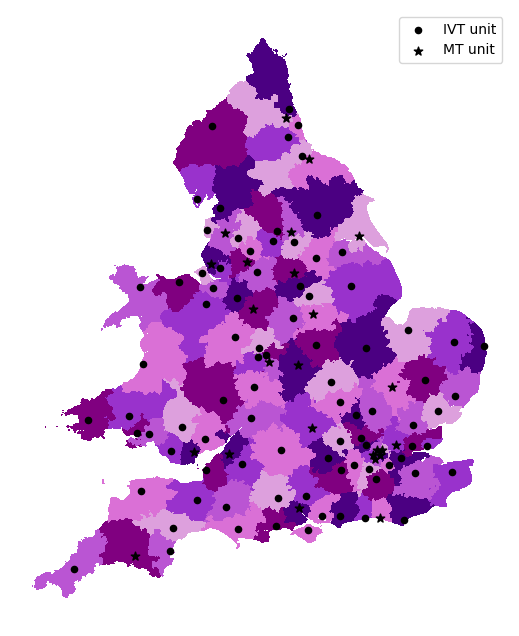

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))

# Catchment areas:
gdf_catchment.plot(
    ax=ax,              # Set which axes to use for plot
    antialiased=False,  # Avoids artefact boundary lines
    color=gdf_catchment['colour_str'],  # set colours using this column
    linewidth=0.2,
    )

# Pick out which stroke units to plot:
mask_ivt = ((gdf_units['use_ivt'] == 1) & (gdf_units['use_mt'] == 0))
mask_mt = (gdf_units['use_mt'] == 1)

# IVT units:
ax.scatter(
    gdf_units.loc[mask_ivt, 'geometry'].x,
    gdf_units.loc[mask_ivt, 'geometry'].y,
    marker='o',
    facecolor='k',
    label='IVT unit',
    s=20,  # size
    )

# MT units:
ax.scatter(
    gdf_units.loc[mask_mt, 'geometry'].x,
    gdf_units.loc[mask_mt, 'geometry'].y,
    marker='*',
    facecolor='k',
    label='MT unit',
    s=40,  # size
    )

# Remove the axis border, ticks, labels...
ax.axis('off')

# Add legend:
ax.legend()

plt.show()

## Northern Ireland

### Load data

__SA travel time__

This dataframe contains one row for each SA in Northern Ireland. There is one column for each stroke unit in Northern Ireland. The value in each cell is the time from that row's SA to that column's stroke unit.

In [27]:
df_travel_sa = stroke_maps.load_data.travel_time_matrix_ni_areas()

# Show the first five rows and columns:
df_travel_sa.iloc[:5, :5]

,BT126BA,BT161RH,BT358DR,BT412RL,BT476SB
from_postcode,,,,,
N00000001,31.400562,37.852665,64.223641,19.032658,79.895643
N00000002,24.677730,37.852665,61.926859,23.292278,83.200000
N00000003,24.677730,37.852665,63.077279,20.471335,80.991077
N00000004,30.080264,42.862547,66.504588,24.677730,83.200000
N00000005,32.710168,40.372700,66.504588,16.088440,76.591575


Write how many SA and then how many stroke teams are in this matrix:

In [28]:
df_travel_sa.shape

(4537, 8)

__Stroke unit services__

This dataframe contains information on which stroke units provide which services (IVT and MT). The imported dataframe, df_units, contains only units that appear in the travel time matrix. This includes units that are not acute stroke units (i.e. provide neither thrombolysis nor thrombectomy).

In [29]:
df_units_ni = stroke_maps.load_data.ni_stroke_unit_services()

df_units_ni.head(3).T

Postcode,BT126BA,BT161RH,BT358DR
Hospital_name,Royal Victoria,Ulster,Daisy Hill
City,Belfast,Belfast,Newry
door_to_needle,43,50,38
Fixed,2.0,NaN,NaN
use_ivt,1,1,0
use_mt,1,0,0


### Calculate nearest acute stroke unit

The full travel time matrix gives the time from every SA to every stroke unit, including those that don't provide acute care. Realistically an ambulance should never choose to take the patient to those units.

Firstly, find a list of stroke units that offer acute care. These are units where `use_ivt` and/or `use_mt` are equal to 1 (one).

In [30]:
mask_acute = ((df_units_ni['use_ivt'] == 1) | (df_units_ni['use_mt'] == 1))

postcodes_acute_units_ni = df_units_ni[mask_acute].index.values

Check how many postcodes are in this list compared with how many stroke units are in the full dataframe:

In [31]:
n_units = len(df_units_ni)
n_units_acute = len(postcodes_acute_units_ni)

print(n_units, n_units_acute)

8 7


Now make a copy of the travel time matrix that only includes times to these units:

In [32]:
df_travel_sa_acute = df_travel_sa[postcodes_acute_units_ni].copy()

# (Number of LSOA, number of stroke teams)
df_travel_sa_acute.shape

(4537, 7)

Run the function to find which of the units in the reduced dataframe is closest to each LSOA:

In [33]:
df_catchment_acute_ni = stroke_maps.catchment.find_nearest_unit(df_travel_sa_acute)

df_catchment_acute_ni.head(5)

,unit_travel_time,unit_postcode
from_postcode,,
N00000001,19.032658,BT412RL
N00000002,23.292278,BT412RL
N00000003,20.471335,BT412RL
N00000004,24.677730,BT412RL
N00000005,16.088440,BT412RL


### Calculate nearest thrombectomy unit

We can use a very similar method to before by only keeping stroke units that offer thrombectomy (MT):

In [34]:
mask_mt = (df_units_ni['use_mt'] == 1)

postcodes_mt_units_ni = df_units_ni[mask_mt].index.values

Check how many postcodes are in this list compared with how many stroke units are in the full dataframe:

In [35]:
n_units = len(df_units_ni)
n_units_mt = len(postcodes_mt_units_ni)

print(n_units, n_units_mt)

8 1


Now make a copy of the travel time matrix that includes times to only these units:

In [36]:
df_travel_sa_mt = df_travel_sa[postcodes_mt_units_ni].copy()

# (Number of LSOA, number of stroke teams)
df_travel_sa_mt.shape

(4537, 1)

Run the function to find which of the units in the reduced dataframe is closest to each LSOA:

In [37]:
df_catchment_mt_ni = stroke_maps.catchment.find_nearest_unit(df_travel_sa_mt)

df_catchment_mt_ni.head(5)

,unit_travel_time,unit_postcode
from_postcode,,
N00000001,31.400562,BT126BA
N00000002,24.677730,BT126BA
N00000003,24.677730,BT126BA
N00000004,30.080264,BT126BA
N00000005,32.710168,BT126BA


### Calculate nearest transfer unit

The method for finding transfer units is shown in more detail in _the transfer units demonstration_ (__TO DO__: add link to this).

In [39]:
df_transfer_ni = stroke_maps.catchment.calculate_transfer_units(df_units_ni, use_northern_ireland=True)

In [40]:
df_transfer_ni

,transfer_unit_travel_time,transfer_unit_postcode
Postcode,,
BT126BA,0.000000,BT126BA
BT161RH,19.032658,BT126BA
BT358DR,NaN,<NA>
BT412RL,28.748618,BT126BA
BT476SB,88.400000,BT126BA
BT521HS,69.897939,BT126BA
BT635QQ,37.852665,BT126BA
BT746DN,104.000000,BT126BA


### Combine results for nearest acute, MT, and transfer units

In [41]:
# Combine nearest unit and nearest MT unit:
df_results_ni = pd.merge(
    df_catchment_acute_ni, df_catchment_mt_ni,
    left_index=True, right_index=True, how='left',
    suffixes=['_acute', '_mt']
)
# Combine these with the nearest unit's transfer unit:
df_results_ni = pd.merge(
    df_results_ni, df_transfer_ni,
    left_on='unit_postcode_acute', right_index=True, how='left',
)

In [42]:
df_results_ni.head(5)

,unit_travel_time_acute,unit_postcode_acute,unit_travel_time_mt,unit_postcode_mt,transfer_unit_travel_time,transfer_unit_postcode
from_postcode,,,,,,
N00000001,19.032658,BT412RL,31.400562,BT126BA,28.748618,BT126BA
N00000002,23.292278,BT412RL,24.677730,BT126BA,28.748618,BT126BA
N00000003,20.471335,BT412RL,24.677730,BT126BA,28.748618,BT126BA
N00000004,24.677730,BT412RL,30.080264,BT126BA,28.748618,BT126BA
N00000005,16.088440,BT412RL,32.710168,BT126BA,28.748618,BT126BA


### Plot the catchment areas

__Set up catchment data for plot__

First, load the Small Area boundaries:

In [43]:
gdf_sa = stroke_maps.load_data.ni_sa_geography()

gdf_sa.head(3)

,OBJECTID,SA2011,SOA2011,X_COORD,Y_COORD,Hectares,Shape_Leng,Shape_Area,Code_all,geometry
0,1,N00000002,95AA01S2,315465,377176,169.044,8476.858446,1.690436e+06,N00000002,"POLYGON ((315481.125 376464.219, 315472.344 37..."
1,2,N00000004,95AA01S2,307147,376182,8700.040,46727.719482,8.700042e+07,N00000004,"POLYGON ((307740.812 382573.219, 307762.250 38..."
2,3,N00000007,95AA01S3,314461,383440,1287.990,21817.292006,1.287995e+07,N00000007,"POLYGON ((311363.312 385217.625, 311600.000 38..."


Merge in the information on nearest acute stroke unit:

In [44]:
gdf_sa = pd.merge(
    gdf_sa, df_results_ni['unit_postcode_acute'],
    left_on='SA2011', right_index=True, how='right'
)

gdf_sa.head(3)

,OBJECTID,SA2011,SOA2011,X_COORD,Y_COORD,Hectares,Shape_Leng,Shape_Area,Code_all,geometry,unit_postcode_acute
6,7,N00000001,95AA01S1,315036,380003,540.076,12921.250935,5.400762e+06,N00000001,"POLYGON ((315795.031 380324.188, 315785.546 38...",BT412RL
0,1,N00000002,95AA01S2,315465,377176,169.044,8476.858446,1.690436e+06,N00000002,"POLYGON ((315481.125 376464.219, 315472.344 37...",BT412RL
4536,4537,N00000003,95AA01S2,316689,378660,500.210,12659.603928,5.002105e+06,N00000003,"POLYGON ((315434.406 378660.625, 315415.500 37...",BT412RL


Combine SA with the same acute stroke unit into a single region:

In [56]:
gdf_catchment_ni = stroke_maps.geo.combine_regions(gdf_sa, 'unit_postcode_acute')

Convert the coordinates to Irish Grid so that they match other geometry:

In [57]:
gdf_catchment_ni = gdf_catchment_ni.to_crs('EPSG:29902')

In [58]:
gdf_catchment_ni

,geometry
unit_postcode_acute,
BT126BA,"MULTIPOLYGON (((330973.812 313545.625, 330964...."
BT161RH,"MULTIPOLYGON (((353700.375 336535.562, 353703...."
BT412RL,"POLYGON ((315133.250 375991.062, 315114.781 37..."
BT476SB,"POLYGON ((241791.359 383254.344, 241778.391 38..."
BT521HS,"MULTIPOLYGON (((285173.500 400934.625, 285178...."
BT635QQ,"MULTIPOLYGON (((292320.812 312793.406, 292324...."
BT746DN,"POLYGON ((234860.312 321458.750, 234858.609 32..."


For plotting the regions here, assign each region a number in the `adjacent_colours` column. Regions that border each other will never be given the same number.

In [59]:
# Use greedy to assign colours wherein adjacent polygons are never the same
# min_distance is the minimal distance between colours
# balance=count means we try to balance number of features per colour
gdf_catchment_ni['adjacent_colours'] = greedy(
    gdf_catchment_ni, min_distance=1, balance='count').astype(str)

Map these numbers to some colour names of our choosing:

In [60]:
# Make a list of colour names:
# Expecting to only need about six colours for this example.
colours = ['Indigo', 'Purple', 'DarkOrchid', 'MediumOrchid', 'Orchid', 'Plum', 'Lavender']

# Make a dictionary of numbers to colours.
# The keys are the numbers in the `adjacent_colours` column:
keys = [f'{i}' for i in range(len(colours))]
colour_map = dict(zip(keys, colours))

# Assign these colours to the regions:
gdf_catchment_ni['colour_str'] = gdf_catchment_ni['adjacent_colours'].map(colour_map)

In [61]:
gdf_catchment_ni

,geometry,adjacent_colours,colour_str
unit_postcode_acute,,,
BT126BA,"MULTIPOLYGON (((330973.812 313545.625, 330964....",3,MediumOrchid
BT161RH,"MULTIPOLYGON (((353700.375 336535.562, 353703....",1,Purple
BT412RL,"POLYGON ((315133.250 375991.062, 315114.781 37...",0,Indigo
BT476SB,"POLYGON ((241791.359 383254.344, 241778.391 38...",1,Purple
BT521HS,"MULTIPOLYGON (((285173.500 400934.625, 285178....",2,DarkOrchid
BT635QQ,"MULTIPOLYGON (((292320.812 312793.406, 292324....",2,DarkOrchid
BT746DN,"POLYGON ((234860.312 321458.750, 234858.609 32...",0,Indigo


__Create the map__

Load in the stroke unit coordinates and merge in the services information:

In [62]:
gdf_units_ni = stroke_maps.load_data.stroke_unit_coordinates_ni()
gdf_units_ni = pd.merge(
    gdf_units_ni, df_units_ni[['use_ivt', 'use_mt']],
    left_index=True, right_index=True, how='right'
)

Plot the unit locations and catchment areas using matplotlib:

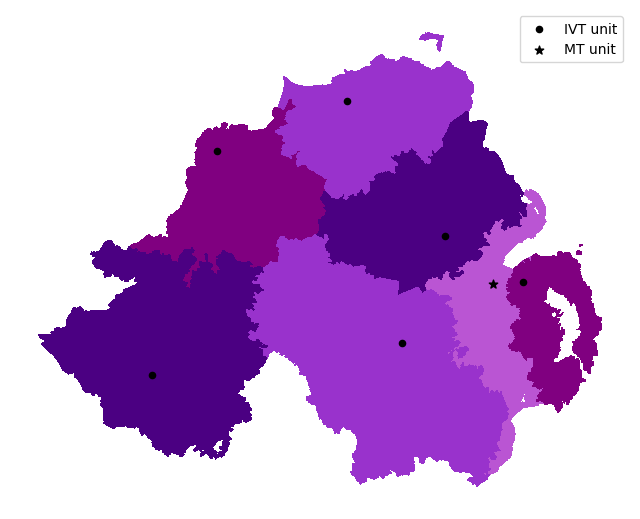

In [63]:
fig, ax = plt.subplots(figsize=(8, 8))

# Catchment areas:
gdf_catchment_ni.plot(
    ax=ax,              # Set which axes to use for plot
    antialiased=False,  # Avoids artefact boundary lines
    color=gdf_catchment_ni['colour_str'],  # set colours using this column
    linewidth=0.2,
    )

# Pick out which stroke units to plot:
mask_ivt = ((gdf_units_ni['use_ivt'] == 1) & (gdf_units_ni['use_mt'] == 0))
mask_mt = (gdf_units_ni['use_mt'] == 1)

# IVT units:
ax.scatter(
    gdf_units_ni.loc[mask_ivt, 'geometry'].x,
    gdf_units_ni.loc[mask_ivt, 'geometry'].y,
    marker='o',
    facecolor='k',
    label='IVT unit',
    s=20,  # size
    )

# MT units:
ax.scatter(
    gdf_units_ni.loc[mask_mt, 'geometry'].x,
    gdf_units_ni.loc[mask_mt, 'geometry'].y,
    marker='*',
    facecolor='k',
    label='MT unit',
    s=40,  # size
    )

# Remove the axis border, ticks, labels...
ax.axis('off')

# Add legend:
ax.legend()

plt.show()

## Conclusion

We have shown how to find the catchment area of each stroke unit and to plot the results.